In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [3]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [4]:
#fakes_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8'
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

#num=3039 #5000
#n_classes=11 #12
#n_epochs=4000 #500
#fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{fakes_suffix}"

dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

In [5]:
dataset_bank_tns_df_resampled_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc91973,0.648056,0.438369,0.306405,0.000000,0.350863,1.296113,1.132292,0.416165,2.372943,-0.013326,...,0.502309,0.721143,0.811645,0.579434,39.665981,0.019535,Fake,TDE,-99.00000,None
ZTFabc46594,0.486110,0.605627,0.258561,0.017279,0.317578,0.937265,0.604629,0.378644,0.566701,-0.007330,...,-0.059388,-0.053494,-0.067460,-0.116639,8.221067,0.055221,Fake,TDE,-99.00000,None
ZTFabc20988,0.447717,0.433476,0.428571,0.000000,0.403265,0.895435,0.820801,0.547785,-0.871551,0.005264,...,0.466027,0.127562,0.206142,0.121683,2.985047,0.021310,Fake,TDE,-99.00000,None


In [6]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.429100,0.487600,0.394600,0.479000,17.508340,0.363381,Yes_TNS,SN Ia,0.076000,ALeRCE
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,1.987599,2.187201,1.923100,1.677900,127.987642,1.280643,Yes_TNS,SN Ic-BL,0.023563,ZTF
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.537500,0.461899,0.366699,0.308001,73.202796,0.245163,Yes_TNS,SN Ia,0.048167,ZTF
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,1.203501,1.442598,1.337000,1.170200,29.489402,0.282454,Yes_TNS,SN Ia,0.041000,ALeRCE
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.024799,-0.047600,0.003399,-0.067900,37.216605,4.749794,Yes_TNS,SN Ia,0.070000,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.869000,1.001200,1.090099,1.092001,48.668157,0.124452,Yes_TNS,SN Ia-91T-like,0.037437,ALeRCE
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.387199,0.329800,0.383400,0.422300,58.550706,0.012833,Yes_TNS,SN Ia,0.097780,AMPEL
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,1.349999,1.271399,1.157599,1.225500,124.418488,0.916609,Yes_TNS,SN Ia,0.040000,ALeRCE


In [7]:
np.unique(np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [24]:
x_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]
x_test = dataset_bank_tns_df_resampled_test.iloc[:, 0:120]

In [21]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.losses import binary_crossentropy, KLDivergence
from keras import backend as K
from keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tqdm import tqdm

# Normalize the input data
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_normalized = (x_train - x_train_mean) / x_train_std

# Define the dimensions
input_dim = 120
latent_dim = 5
intermediate_dim = 64

# Encoder
input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(intermediate_dim, activation='relu')(input_layer)

# Define the mean and variance of the latent distribution
z_mean = Dense(latent_dim)(hidden_layer)
z_log_var = Dense(latent_dim)(hidden_layer)

# Custom layer for reparameterization trick
class SamplingLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = SamplingLayer()([z_mean, z_log_var])

# Decoder
decoder_hidden = Dense(intermediate_dim, activation='relu')
decoder_output = Dense(input_dim, activation='linear')  # Modified activation function

# Define the VAE model
decoder_mean = decoder_output(decoder_hidden(z))
vae = Model(input_layer, decoder_mean)

# Define the reconstruction loss
reconstruction_loss = input_dim * binary_crossentropy(input_layer, decoder_mean)

# Define the KL divergence loss
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

# Add the reconstruction and KL divergence losses as additional losses
vae.add_loss(K.mean(reconstruction_loss + kl_loss))

# Compile the model
vae.compile(optimizer='adam')

# Define a callback for updating the progress bar
progress_bar = tqdm(unit="batch", total=len(x_train) // 32)
progress_callback = LambdaCallback(on_batch_end=lambda batch, logs: progress_bar.update(1) if (batch + 1) % 32 == 0 else False)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the VAE
vae.fit(
    x_train_normalized, x_train_normalized,
    batch_size=32,
    epochs=50,
    callbacks=[progress_callback, reduce_lr],
    #validation_data=(x_val_normalized, x_val_normalized)  # Assuming you have a validation set
)

# Close the progress bar after training
progress_bar.close()

# Obtain the latent representation of the input data
encoder = Model(input_layer, z_mean)
latent_representation = encoder.predict(x_train)

  0%|          | 0/996 [00:16<?, ?batch/s]

Epoch 1/50


 31/996 [..............................] - ETA: 1s - loss: -6.2995    

  0%|          | 1/996 [00:00<14:19,  1.16batch/s]

 81/996 [=>............................] - ETA: 1s - loss: -48.2451

  0%|          | 3/996 [00:00<04:28,  3.70batch/s]

179/996 [====>.........................] - ETA: 1s - loss: 5.1535 

  1%|          | 6/996 [00:01<02:12,  7.45batch/s]

252/996 [======>.......................] - ETA: 1s - loss: -55.7986

  1%|          | 8/996 [00:01<01:49,  9.04batch/s]

303/996 [========>.....................] - ETA: 1s - loss: -88.8726

  1%|          | 10/996 [00:01<01:32, 10.64batch/s]

406/996 [===========>..................] - ETA: 1s - loss: -139.3103

  1%|▏         | 13/996 [00:01<01:12, 13.60batch/s]

479/996 [=============>................] - ETA: 0s - loss: -163.9749

  2%|▏         | 16/996 [00:01<01:00, 16.08batch/s]

586/996 [================>.............] - ETA: 0s - loss: -196.4054

  2%|▏         | 19/996 [00:01<00:55, 17.68batch/s]

693/996 [===================>..........] - ETA: 0s - loss: -219.0041

  2%|▏         | 22/996 [00:01<00:51, 18.88batch/s]

776/996 [======================>.......] - ETA: 0s - loss: -234.1003

  3%|▎         | 25/996 [00:02<00:52, 18.35batch/s]

835/996 [========================>.....] - ETA: 0s - loss: -243.3704

  3%|▎         | 27/996 [00:02<00:52, 18.42batch/s]

937/996 [===========================>..] - ETA: 0s - loss: -257.7460

  3%|▎         | 30/996 [00:02<00:50, 19.28batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -264.4070 - lr: 0.0010
Epoch 2/50
  1/996 [..............................] - ETA: 2s - loss: -281.0806

  3%|▎         | 32/996 [00:02<00:51, 18.82batch/s]

100/996 [==>...........................] - ETA: 1s - loss: -383.1320

  4%|▎         | 35/996 [00:02<00:48, 19.64batch/s]

208/996 [=====>........................] - ETA: 1s - loss: -388.7275

  4%|▍         | 38/996 [00:02<00:47, 20.21batch/s]

311/996 [========>.....................] - ETA: 1s - loss: -390.6236

  4%|▍         | 41/996 [00:02<00:46, 20.47batch/s]

415/996 [===========>..................] - ETA: 0s - loss: -392.1888

  4%|▍         | 44/996 [00:03<00:45, 20.84batch/s]

489/996 [=============>................] - ETA: 0s - loss: -388.0323

  5%|▍         | 47/996 [00:03<00:44, 21.50batch/s]

596/996 [================>.............] - ETA: 0s - loss: -381.1877

  5%|▌         | 50/996 [00:03<00:43, 21.52batch/s]

701/996 [====================>.........] - ETA: 0s - loss: -379.9447

  5%|▌         | 53/996 [00:03<00:43, 21.61batch/s]

773/996 [======================>.......] - ETA: 0s - loss: -377.9045

  6%|▌         | 56/996 [00:03<00:42, 21.91batch/s]

880/996 [=========================>....] - ETA: 0s - loss: -373.0663

  6%|▌         | 59/996 [00:03<00:43, 21.79batch/s]

981/996 [============================>.] - ETA: 0s - loss: -373.9488

  6%|▌         | 62/996 [00:03<00:43, 21.34batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -374.1954 - lr: 0.0010
Epoch 3/50
 62/996 [>.............................] - ETA: 1s - loss: -369.6248

  7%|▋         | 65/996 [00:04<00:45, 20.46batch/s]

166/996 [====>.........................] - ETA: 1s - loss: -380.0847

  7%|▋         | 68/996 [00:04<00:45, 20.43batch/s]

257/996 [======>.......................] - ETA: 1s - loss: -385.4165

  7%|▋         | 71/996 [00:04<00:46, 19.79batch/s]

344/996 [=========>....................] - ETA: 1s - loss: -388.4447

  7%|▋         | 73/996 [00:04<00:48, 19.07batch/s]

447/996 [============>.................] - ETA: 0s - loss: -385.8039

  8%|▊         | 76/996 [00:04<00:46, 19.81batch/s]

519/996 [==============>...............] - ETA: 0s - loss: -386.1266

  8%|▊         | 79/996 [00:04<00:44, 20.57batch/s]

630/996 [=================>............] - ETA: 0s - loss: -385.5010

  8%|▊         | 82/996 [00:04<00:43, 21.16batch/s]

721/996 [====================>.........] - ETA: 0s - loss: -386.8679

  9%|▊         | 85/996 [00:05<00:45, 20.22batch/s]

819/996 [=======================>......] - ETA: 0s - loss: -389.7282

  9%|▉         | 88/996 [00:05<00:44, 20.25batch/s]

910/996 [==========================>...] - ETA: 0s - loss: -392.3498

  9%|▉         | 91/996 [00:05<00:46, 19.35batch/s]

968/996 [============================>.] - ETA: 0s - loss: -395.1374

  9%|▉         | 93/996 [00:05<00:46, 19.29batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -396.4160 - lr: 0.0010
Epoch 4/50
 34/996 [>.............................] - ETA: 1s - loss: -413.2490

 10%|▉         | 95/996 [00:05<00:47, 19.06batch/s]

 99/996 [=>............................] - ETA: 1s - loss: -406.6155

 10%|▉         | 97/996 [00:05<00:46, 19.25batch/s]

162/996 [===>..........................] - ETA: 1s - loss: -413.3305

 10%|▉         | 99/996 [00:05<00:46, 19.42batch/s]

266/996 [=======>......................] - ETA: 1s - loss: -418.9624

 10%|█         | 102/996 [00:05<00:44, 20.07batch/s]

366/996 [==========>...................] - ETA: 0s - loss: -418.7622

 11%|█         | 105/996 [00:06<00:44, 20.23batch/s]

463/996 [============>.................] - ETA: 0s - loss: -416.0227

 11%|█         | 108/996 [00:06<00:44, 19.97batch/s]

527/996 [==============>...............] - ETA: 0s - loss: -413.2931

 11%|█         | 110/996 [00:06<00:44, 19.89batch/s]

588/996 [================>.............] - ETA: 0s - loss: -415.0536

 11%|█         | 112/996 [00:06<00:44, 19.71batch/s]

651/996 [==================>...........] - ETA: 0s - loss: -417.1866

 11%|█▏        | 114/996 [00:06<00:44, 19.66batch/s]

751/996 [=====================>........] - ETA: 0s - loss: -419.3724

 12%|█▏        | 117/996 [00:06<00:44, 19.90batch/s]

851/996 [========================>.....] - ETA: 0s - loss: -419.2444

 12%|█▏        | 120/996 [00:06<00:43, 20.19batch/s]

950/996 [===========================>..] - ETA: 0s - loss: -417.7034

 12%|█▏        | 123/996 [00:06<00:43, 20.14batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -414.7928 - lr: 0.0010
Epoch 5/50
 32/996 [..............................] - ETA: 1s - loss: -384.2126

 13%|█▎        | 126/996 [00:07<00:44, 19.52batch/s]

132/996 [==>...........................] - ETA: 1s - loss: -383.0778

 13%|█▎        | 129/996 [00:07<00:44, 19.69batch/s]

192/996 [====>.........................] - ETA: 1s - loss: -388.0013

 13%|█▎        | 131/996 [00:07<00:44, 19.39batch/s]

294/996 [=======>......................] - ETA: 1s - loss: -398.4046

 13%|█▎        | 134/996 [00:07<00:42, 20.10batch/s]

401/996 [===========>..................] - ETA: 0s - loss: -403.7756

 14%|█▍        | 137/996 [00:07<00:41, 20.62batch/s]

508/996 [==============>...............] - ETA: 0s - loss: -408.2095

 14%|█▍        | 140/996 [00:07<00:40, 21.05batch/s]

572/996 [================>.............] - ETA: 0s - loss: -410.9357

 14%|█▍        | 143/996 [00:07<00:40, 20.96batch/s]

677/996 [===================>..........] - ETA: 0s - loss: -411.3602

 15%|█▍        | 146/996 [00:08<00:40, 21.06batch/s]

783/996 [======================>.......] - ETA: 0s - loss: -414.3988

 15%|█▍        | 149/996 [00:08<00:39, 21.29batch/s]

884/996 [=========================>....] - ETA: 0s - loss: -415.9681

 15%|█▌        | 152/996 [00:08<00:40, 20.98batch/s]

986/996 [============================>.] - ETA: 0s - loss: -415.9253

 16%|█▌        | 155/996 [00:08<00:40, 20.98batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -415.9536 - lr: 0.0010
Epoch 6/50
 66/996 [>.............................] - ETA: 1s - loss: -413.9509

 16%|█▌        | 158/996 [00:08<00:41, 20.13batch/s]

174/996 [====>.........................] - ETA: 1s - loss: -419.8434

 16%|█▌        | 161/996 [00:08<00:39, 20.92batch/s]

276/996 [=======>......................] - ETA: 1s - loss: -427.6625

 16%|█▋        | 164/996 [00:08<00:40, 20.77batch/s]

369/996 [==========>...................] - ETA: 0s - loss: -432.0881

 17%|█▋        | 167/996 [00:09<00:40, 20.25batch/s]

466/996 [=============>................] - ETA: 0s - loss: -431.1342

 17%|█▋        | 170/996 [00:09<00:40, 20.20batch/s]

561/996 [===============>..............] - ETA: 0s - loss: -434.3435

 17%|█▋        | 173/996 [00:09<00:41, 19.93batch/s]

623/996 [=================>............] - ETA: 0s - loss: -435.6650

 18%|█▊        | 175/996 [00:09<00:41, 19.76batch/s]

725/996 [====================>.........] - ETA: 0s - loss: -434.4147

 18%|█▊        | 178/996 [00:09<00:40, 20.18batch/s]

823/996 [=======================>......] - ETA: 0s - loss: -417.2665

 18%|█▊        | 181/996 [00:09<00:40, 20.11batch/s]

926/996 [==========================>...] - ETA: 0s - loss: -409.9442

 18%|█▊        | 184/996 [00:09<00:39, 20.45batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -406.3064 - lr: 0.0010
Epoch 7/50
 26/996 [..............................] - ETA: 1s - loss: -409.0482

 19%|█▉        | 187/996 [00:10<00:44, 18.31batch/s]

 91/996 [=>............................] - ETA: 1s - loss: -387.5312

 19%|█▉        | 189/996 [00:10<00:43, 18.66batch/s]

159/996 [===>..........................] - ETA: 1s - loss: -382.3322

 19%|█▉        | 192/996 [00:10<00:41, 19.40batch/s]

264/996 [======>.......................] - ETA: 1s - loss: -384.8390

 20%|█▉        | 195/996 [00:10<00:39, 20.27batch/s]

372/996 [==========>...................] - ETA: 0s - loss: -388.7446

 20%|█▉        | 198/996 [00:10<00:38, 20.79batch/s]

446/996 [============>.................] - ETA: 0s - loss: -393.5539

 20%|██        | 201/996 [00:10<00:36, 21.52batch/s]

544/996 [===============>..............] - ETA: 0s - loss: -397.7357

 20%|██        | 204/996 [00:10<00:38, 20.68batch/s]

671/996 [===================>..........] - ETA: 0s - loss: -400.0637

 21%|██        | 207/996 [00:11<00:38, 20.25batch/s]

734/996 [=====================>........] - ETA: 0s - loss: -400.9489

 21%|██        | 210/996 [00:11<00:38, 20.20batch/s]

860/996 [========================>.....] - ETA: 0s - loss: -404.7986

 21%|██▏       | 213/996 [00:11<00:39, 19.68batch/s]

924/996 [==========================>...] - ETA: 0s - loss: -407.2338

 22%|██▏       | 215/996 [00:11<00:39, 19.72batch/s]

988/996 [============================>.] - ETA: 0s - loss: -408.7206

 22%|██▏       | 217/996 [00:11<00:39, 19.74batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -408.8133 - lr: 0.0010
Epoch 8/50
 57/996 [>.............................] - ETA: 1s - loss: -434.1660

 22%|██▏       | 219/996 [00:11<00:41, 18.56batch/s]

115/996 [==>...........................] - ETA: 1s - loss: -427.0719

 22%|██▏       | 221/996 [00:11<00:41, 18.46batch/s]

178/996 [====>.........................] - ETA: 1s - loss: -423.7015

 22%|██▏       | 223/996 [00:11<00:41, 18.63batch/s]

239/996 [======>.......................] - ETA: 1s - loss: -423.2940

 23%|██▎       | 225/996 [00:12<00:41, 18.65batch/s]

300/996 [========>.....................] - ETA: 1s - loss: -427.9959

 23%|██▎       | 227/996 [00:12<00:40, 18.91batch/s]

411/996 [===========>..................] - ETA: 0s - loss: -431.9422

 23%|██▎       | 230/996 [00:12<00:37, 20.26batch/s]

481/996 [=============>................] - ETA: 0s - loss: -433.1501

 23%|██▎       | 233/996 [00:12<00:36, 20.71batch/s]

578/996 [================>.............] - ETA: 0s - loss: -432.5290

 24%|██▎       | 236/996 [00:12<00:37, 20.17batch/s]

672/996 [===================>..........] - ETA: 0s - loss: -434.8543

 24%|██▍       | 239/996 [00:12<00:37, 20.14batch/s]

772/996 [======================>.......] - ETA: 0s - loss: -437.2056

 24%|██▍       | 242/996 [00:12<00:37, 20.10batch/s]

894/996 [=========================>....] - ETA: 0s - loss: -436.9574

 25%|██▍       | 245/996 [00:13<00:38, 19.50batch/s]

960/996 [===========================>..] - ETA: 0s - loss: -435.9437

 25%|██▍       | 248/996 [00:13<00:37, 19.80batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -435.6283 - lr: 0.0010
Epoch 9/50
 34/996 [>.............................] - ETA: 1s - loss: -460.2998

 25%|██▌       | 250/996 [00:13<00:38, 19.38batch/s]

 95/996 [=>............................] - ETA: 1s - loss: -442.1440

 25%|██▌       | 252/996 [00:13<00:38, 19.32batch/s]

160/996 [===>..........................] - ETA: 1s - loss: -446.4281

 26%|██▌       | 254/996 [00:13<00:38, 19.45batch/s]

263/996 [======>.......................] - ETA: 1s - loss: -442.7121

 26%|██▌       | 257/996 [00:13<00:36, 20.32batch/s]

365/996 [=========>....................] - ETA: 0s - loss: -442.1649

 26%|██▌       | 260/996 [00:13<00:36, 20.32batch/s]

461/996 [============>.................] - ETA: 0s - loss: -444.9496

 26%|██▋       | 263/996 [00:13<00:36, 20.12batch/s]

554/996 [===============>..............] - ETA: 0s - loss: -445.5825

 27%|██▋       | 266/996 [00:14<00:37, 19.39batch/s]

651/996 [==================>...........] - ETA: 0s - loss: -445.7610

 27%|██▋       | 269/996 [00:14<00:37, 19.60batch/s]

712/996 [====================>.........] - ETA: 0s - loss: -445.4677

 27%|██▋       | 271/996 [00:14<00:37, 19.41batch/s]

775/996 [======================>.......] - ETA: 0s - loss: -446.1771

 27%|██▋       | 273/996 [00:14<00:37, 19.39batch/s]

873/996 [=========================>....] - ETA: 0s - loss: -445.5488

 28%|██▊       | 276/996 [00:14<00:36, 19.69batch/s]

935/996 [===========================>..] - ETA: 0s - loss: -444.5067

 28%|██▊       | 278/996 [00:14<00:36, 19.52batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -443.9093 - lr: 0.0010
Epoch 10/50
  1/996 [..............................] - ETA: 2s - loss: -414.2105

 28%|██▊       | 280/996 [00:14<00:37, 19.13batch/s]

 94/996 [=>............................] - ETA: 1s - loss: -401.5553

 28%|██▊       | 282/996 [00:14<00:37, 19.01batch/s]

157/996 [===>..........................] - ETA: 1s - loss: -396.8242

 29%|██▊       | 284/996 [00:15<00:37, 19.15batch/s]

226/996 [=====>........................] - ETA: 1s - loss: -400.0940

 29%|██▉       | 287/996 [00:15<00:35, 19.91batch/s]

289/996 [=======>......................] - ETA: 1s - loss: -403.3690

 29%|██▉       | 289/996 [00:15<00:35, 19.75batch/s]

351/996 [=========>....................] - ETA: 1s - loss: -409.4466

 29%|██▉       | 291/996 [00:15<00:35, 19.60batch/s]

450/996 [============>.................] - ETA: 0s - loss: -411.1136

 30%|██▉       | 294/996 [00:15<00:35, 19.95batch/s]

517/996 [==============>...............] - ETA: 0s - loss: -413.4227

 30%|██▉       | 296/996 [00:15<00:35, 19.91batch/s]

616/996 [=================>............] - ETA: 0s - loss: -417.5959

 30%|███       | 299/996 [00:15<00:34, 20.27batch/s]

713/996 [====================>.........] - ETA: 0s - loss: -422.1047

 30%|███       | 302/996 [00:15<00:34, 19.93batch/s]

810/996 [=======================>......] - ETA: 0s - loss: -425.5401

 31%|███       | 305/996 [00:16<00:34, 19.96batch/s]

874/996 [=========================>....] - ETA: 0s - loss: -427.4742

 31%|███       | 307/996 [00:16<00:34, 19.92batch/s]

979/996 [============================>.] - ETA: 0s - loss: -431.7887

 31%|███       | 310/996 [00:16<00:33, 20.37batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -432.1212 - lr: 0.0010
Epoch 11/50
 66/996 [>.............................] - ETA: 1s - loss: -469.3821

 31%|███▏      | 313/996 [00:16<00:34, 19.74batch/s]

164/996 [===>..........................] - ETA: 1s - loss: -461.3215

 32%|███▏      | 316/996 [00:16<00:33, 20.07batch/s]

268/996 [=======>......................] - ETA: 1s - loss: -458.5562

 32%|███▏      | 319/996 [00:16<00:33, 20.34batch/s]

367/996 [==========>...................] - ETA: 0s - loss: -458.5468

 32%|███▏      | 322/996 [00:16<00:33, 20.26batch/s]

468/996 [=============>................] - ETA: 0s - loss: -459.2910

 33%|███▎      | 325/996 [00:17<00:32, 20.37batch/s]

568/996 [================>.............] - ETA: 0s - loss: -458.1773

 33%|███▎      | 328/996 [00:17<00:32, 20.42batch/s]

664/996 [===================>..........] - ETA: 0s - loss: -459.3752

 33%|███▎      | 331/996 [00:17<00:33, 20.14batch/s]

749/996 [=====================>........] - ETA: 0s - loss: -459.6959

 34%|███▎      | 334/996 [00:17<00:34, 19.17batch/s]

831/996 [========================>.....] - ETA: 0s - loss: -457.2901

 34%|███▎      | 336/996 [00:17<00:35, 18.58batch/s]

904/996 [==========================>...] - ETA: 0s - loss: -360.4286

 34%|███▍      | 339/996 [00:17<00:33, 19.76batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -366.7239 - lr: 0.0010
Epoch 12/50
  1/996 [..............................] - ETA: 2s - loss: -476.6468

 34%|███▍      | 342/996 [00:17<00:32, 19.85batch/s]

107/996 [==>...........................] - ETA: 1s - loss: -442.8613

 35%|███▍      | 345/996 [00:18<00:31, 20.56batch/s]

216/996 [=====>........................] - ETA: 1s - loss: -443.0375

 35%|███▍      | 348/996 [00:18<00:30, 21.06batch/s]

285/996 [=======>......................] - ETA: 1s - loss: -444.1279

 35%|███▌      | 351/996 [00:18<00:30, 21.27batch/s]

389/996 [==========>...................] - ETA: 0s - loss: -444.1599

 36%|███▌      | 354/996 [00:18<00:30, 20.99batch/s]

487/996 [=============>................] - ETA: 0s - loss: -447.3991

 36%|███▌      | 357/996 [00:18<00:30, 20.79batch/s]

593/996 [================>.............] - ETA: 0s - loss: -450.9267

 36%|███▌      | 360/996 [00:18<00:30, 21.18batch/s]

680/996 [===================>..........] - ETA: 0s - loss: -451.2950

 36%|███▋      | 363/996 [00:18<00:31, 20.04batch/s]

777/996 [======================>.......] - ETA: 0s - loss: -449.2022

 37%|███▋      | 366/996 [00:19<00:31, 20.04batch/s]

878/996 [=========================>....] - ETA: 0s - loss: -448.0930

 37%|███▋      | 369/996 [00:19<00:30, 20.28batch/s]

974/996 [============================>.] - ETA: 0s - loss: -447.9507

 37%|███▋      | 372/996 [00:19<00:31, 20.06batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -447.9947 - lr: 0.0010
Epoch 13/50
 89/996 [=>............................] - ETA: 1s - loss: -458.9351

 38%|███▊      | 375/996 [00:19<00:32, 18.99batch/s]

156/996 [===>..........................] - ETA: 1s - loss: -464.8294

 38%|███▊      | 377/996 [00:19<00:35, 17.44batch/s]

211/996 [=====>........................] - ETA: 1s - loss: -463.8214

 38%|███▊      | 379/996 [00:19<00:35, 17.43batch/s]

275/996 [=======>......................] - ETA: 1s - loss: -466.0241

 38%|███▊      | 381/996 [00:19<00:34, 17.90batch/s]

381/996 [==========>...................] - ETA: 1s - loss: -469.6689

 39%|███▊      | 384/996 [00:20<00:31, 19.19batch/s]

454/996 [============>.................] - ETA: 0s - loss: -473.6664

 39%|███▉      | 387/996 [00:20<00:30, 20.28batch/s]

562/996 [===============>..............] - ETA: 0s - loss: -473.4475

 39%|███▉      | 390/996 [00:20<00:29, 20.70batch/s]

634/996 [==================>...........] - ETA: 0s - loss: -473.7799

 39%|███▉      | 393/996 [00:20<00:28, 21.41batch/s]

731/996 [=====================>........] - ETA: 0s - loss: -475.3047

 40%|███▉      | 396/996 [00:20<00:28, 20.82batch/s]

841/996 [========================>.....] - ETA: 0s - loss: -476.5498

 40%|████      | 399/996 [00:20<00:28, 21.30batch/s]

950/996 [===========================>..] - ETA: 0s - loss: -474.9124

 40%|████      | 402/996 [00:20<00:27, 21.49batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -475.1234 - lr: 0.0010
Epoch 14/50
 35/996 [>.............................] - ETA: 1s - loss: -482.8935

 41%|████      | 405/996 [00:21<00:28, 20.82batch/s]

135/996 [===>..........................] - ETA: 1s - loss: -475.3548

 41%|████      | 408/996 [00:21<00:28, 20.49batch/s]

235/996 [======>.......................] - ETA: 1s - loss: -469.1304

 41%|████▏     | 411/996 [00:21<00:28, 20.42batch/s]

331/996 [========>.....................] - ETA: 1s - loss: -468.4276

 42%|████▏     | 414/996 [00:21<00:28, 20.23batch/s]

432/996 [============>.................] - ETA: 0s - loss: -467.0887

 42%|████▏     | 417/996 [00:21<00:28, 20.30batch/s]

531/996 [==============>...............] - ETA: 0s - loss: -470.3840

 42%|████▏     | 420/996 [00:21<00:28, 20.25batch/s]

623/996 [=================>............] - ETA: 0s - loss: -468.7081

 42%|████▏     | 423/996 [00:21<00:28, 19.86batch/s]

726/996 [====================>.........] - ETA: 0s - loss: -467.3995

 43%|████▎     | 426/996 [00:22<00:28, 20.32batch/s]

830/996 [========================>.....] - ETA: 0s - loss: -463.7033

 43%|████▎     | 429/996 [00:22<00:27, 20.61batch/s]

927/996 [==========================>...] - ETA: 0s - loss: -463.2001

 43%|████▎     | 432/996 [00:22<00:27, 20.38batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -464.0311 - lr: 0.0010
Epoch 15/50
  1/996 [..............................] - ETA: 2s - loss: -405.8698

 44%|████▎     | 435/996 [00:22<00:28, 19.88batch/s]

 98/996 [=>............................] - ETA: 1s - loss: -461.5346

 44%|████▍     | 438/996 [00:22<00:27, 20.17batch/s]

202/996 [=====>........................] - ETA: 1s - loss: -460.5004

 44%|████▍     | 441/996 [00:22<00:27, 20.19batch/s]

316/996 [========>.....................] - ETA: 1s - loss: -467.5096

 45%|████▍     | 444/996 [00:23<00:28, 19.28batch/s]

380/996 [==========>...................] - ETA: 0s - loss: -458.0838

 45%|████▍     | 446/996 [00:23<00:28, 19.40batch/s]

452/996 [============>.................] - ETA: 0s - loss: -451.6492

 45%|████▌     | 449/996 [00:23<00:26, 20.34batch/s]

558/996 [===============>..............] - ETA: 0s - loss: -451.7638

 45%|████▌     | 452/996 [00:23<00:26, 20.73batch/s]

669/996 [===================>..........] - ETA: 0s - loss: -453.6501

 46%|████▌     | 455/996 [00:23<00:25, 21.38batch/s]

743/996 [=====================>........] - ETA: 0s - loss: -455.8988

 46%|████▌     | 458/996 [00:23<00:24, 21.76batch/s]

845/996 [========================>.....] - ETA: 0s - loss: -455.5488

 46%|████▋     | 461/996 [00:23<00:24, 21.42batch/s]

953/996 [===========================>..] - ETA: 0s - loss: -457.1303

 47%|████▋     | 464/996 [00:23<00:24, 21.71batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -457.4629 - lr: 0.0010
Epoch 16/50
 37/996 [>.............................] - ETA: 1s - loss: -454.0957

 47%|████▋     | 467/996 [00:24<00:25, 21.10batch/s]

136/996 [===>..........................] - ETA: 1s - loss: -478.3365

 47%|████▋     | 470/996 [00:24<00:24, 21.05batch/s]

232/996 [=====>........................] - ETA: 1s - loss: -478.6140

 47%|████▋     | 473/996 [00:24<00:25, 20.38batch/s]

330/996 [========>.....................] - ETA: 1s - loss: -478.8968

 48%|████▊     | 476/996 [00:24<00:25, 20.33batch/s]

432/996 [============>.................] - ETA: 0s - loss: -482.6851

 48%|████▊     | 479/996 [00:24<00:25, 20.65batch/s]

537/996 [===============>..............] - ETA: 0s - loss: -484.9229

 48%|████▊     | 482/996 [00:24<00:24, 20.84batch/s]

634/996 [==================>...........] - ETA: 0s - loss: -485.4755

 49%|████▊     | 485/996 [00:24<00:24, 20.59batch/s]

733/996 [=====================>........] - ETA: 0s - loss: -486.5831

 49%|████▉     | 488/996 [00:25<00:24, 20.50batch/s]

802/996 [=======================>......] - ETA: 0s - loss: -487.1786

 49%|████▉     | 491/996 [00:25<00:24, 20.91batch/s]

896/996 [=========================>....] - ETA: 0s - loss: -484.9517

 50%|████▉     | 494/996 [00:25<00:24, 20.38batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -482.2446 - lr: 0.0010
Epoch 17/50
  1/996 [..............................] - ETA: 2s - loss: -398.0043

 50%|████▉     | 497/996 [00:25<00:24, 20.31batch/s]

107/996 [==>...........................] - ETA: 1s - loss: -457.8777

 50%|█████     | 500/996 [00:25<00:23, 20.95batch/s]

220/996 [=====>........................] - ETA: 1s - loss: -459.7914

 51%|█████     | 503/996 [00:25<00:22, 21.55batch/s]

292/996 [=======>......................] - ETA: 0s - loss: -459.2948

 51%|█████     | 506/996 [00:25<00:22, 21.91batch/s]

399/996 [===========>..................] - ETA: 0s - loss: -55.5474

 51%|█████     | 509/996 [00:26<00:22, 21.89batch/s]

510/996 [==============>...............] - ETA: 0s - loss: -148.2653

 51%|█████▏    | 512/996 [00:26<00:21, 22.11batch/s]

582/996 [================>.............] - ETA: 0s - loss: -187.9186

 52%|█████▏    | 515/996 [00:26<00:21, 21.95batch/s]

681/996 [===================>..........] - ETA: 0s - loss: -227.0717

 52%|█████▏    | 518/996 [00:26<00:22, 21.66batch/s]

792/996 [======================>.......] - ETA: 0s - loss: -260.3239

 52%|█████▏    | 521/996 [00:26<00:21, 21.99batch/s]

865/996 [=========================>....] - ETA: 0s - loss: -277.3274

 53%|█████▎    | 524/996 [00:26<00:21, 22.24batch/s]

977/996 [============================>.] - ETA: 0s - loss: -299.5390

 53%|█████▎    | 527/996 [00:26<00:20, 22.35batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -302.9074 - lr: 0.0010
Epoch 18/50
 76/996 [=>............................] - ETA: 1s - loss: -466.5665

 53%|█████▎    | 530/996 [00:27<00:21, 21.99batch/s]

186/996 [====>.........................] - ETA: 1s - loss: -467.1318

 54%|█████▎    | 533/996 [00:27<00:20, 22.19batch/s]

258/996 [======>.......................] - ETA: 1s - loss: -472.7354

 54%|█████▍    | 536/996 [00:27<00:20, 22.32batch/s]

364/996 [=========>....................] - ETA: 0s - loss: -473.6884

 54%|█████▍    | 539/996 [00:27<00:20, 22.07batch/s]

476/996 [=============>................] - ETA: 0s - loss: -476.3343

 54%|█████▍    | 542/996 [00:27<00:20, 22.27batch/s]

574/996 [================>.............] - ETA: 0s - loss: -479.4954

 55%|█████▍    | 545/996 [00:27<00:20, 21.53batch/s]

645/996 [==================>...........] - ETA: 0s - loss: -480.4277

 55%|█████▌    | 548/996 [00:27<00:20, 21.85batch/s]

748/996 [=====================>........] - ETA: 0s - loss: -484.4698

 55%|█████▌    | 551/996 [00:27<00:20, 21.39batch/s]

845/996 [========================>.....] - ETA: 0s - loss: -484.7236

 56%|█████▌    | 554/996 [00:28<00:21, 20.95batch/s]

943/996 [===========================>..] - ETA: 0s - loss: -486.7831

 56%|█████▌    | 557/996 [00:28<00:21, 20.70batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -487.7697 - lr: 0.0010
Epoch 19/50
 34/996 [>.............................] - ETA: 1s - loss: -484.7242

 56%|█████▌    | 560/996 [00:28<00:21, 19.88batch/s]

118/996 [==>...........................] - ETA: 1s - loss: -484.9907

 56%|█████▋    | 562/996 [00:28<00:22, 18.99batch/s]

223/996 [=====>........................] - ETA: 1s - loss: -493.7091

 57%|█████▋    | 565/996 [00:28<00:21, 19.85batch/s]

288/996 [=======>......................] - ETA: 1s - loss: -496.4381

 57%|█████▋    | 568/996 [00:28<00:21, 20.12batch/s]

397/996 [==========>...................] - ETA: 0s - loss: -498.9010

 57%|█████▋    | 571/996 [00:28<00:20, 20.78batch/s]

504/996 [==============>...............] - ETA: 0s - loss: -493.9849

 58%|█████▊    | 574/996 [00:29<00:19, 21.12batch/s]

576/996 [================>.............] - ETA: 0s - loss: -496.0391

 58%|█████▊    | 577/996 [00:29<00:19, 21.60batch/s]

677/996 [===================>..........] - ETA: 0s - loss: -498.5838

 58%|█████▊    | 580/996 [00:29<00:19, 20.91batch/s]

777/996 [======================>.......] - ETA: 0s - loss: -498.2032

 59%|█████▊    | 583/996 [00:29<00:19, 21.04batch/s]

879/996 [=========================>....] - ETA: 0s - loss: -499.4567

 59%|█████▉    | 586/996 [00:29<00:19, 20.81batch/s]

976/996 [============================>.] - ETA: 0s - loss: -500.6616

 59%|█████▉    | 589/996 [00:29<00:19, 20.59batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -500.8170 - lr: 0.0010
Epoch 20/50
 67/996 [=>............................] - ETA: 1s - loss: -510.6602

 59%|█████▉    | 592/996 [00:30<00:20, 20.05batch/s]

169/996 [====>.........................] - ETA: 1s - loss: -496.7675

 60%|█████▉    | 595/996 [00:30<00:19, 20.37batch/s]

272/996 [=======>......................] - ETA: 1s - loss: -493.8505

 60%|██████    | 598/996 [00:30<00:19, 20.47batch/s]

370/996 [==========>...................] - ETA: 0s - loss: -493.6945

 60%|██████    | 601/996 [00:30<00:19, 20.41batch/s]

472/996 [=============>................] - ETA: 0s - loss: -495.8757

 61%|██████    | 604/996 [00:30<00:19, 20.32batch/s]

572/996 [================>.............] - ETA: 0s - loss: -493.9690

 61%|██████    | 607/996 [00:30<00:19, 20.44batch/s]

643/996 [==================>...........] - ETA: 0s - loss: -495.9998

 61%|██████    | 610/996 [00:30<00:18, 20.77batch/s]

740/996 [=====================>........] - ETA: 0s - loss: -496.5791

 62%|██████▏   | 613/996 [00:31<00:18, 20.50batch/s]

839/996 [========================>.....] - ETA: 0s - loss: -493.6958

 62%|██████▏   | 616/996 [00:31<00:18, 20.31batch/s]

936/996 [===========================>..] - ETA: 0s - loss: -490.5186

 62%|██████▏   | 619/996 [00:31<00:18, 20.25batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -490.2173 - lr: 0.0010
Epoch 21/50
 34/996 [>.............................] - ETA: 1s - loss: -479.3969

 62%|██████▏   | 622/996 [00:31<00:19, 19.59batch/s]

 99/996 [=>............................] - ETA: 1s - loss: -485.5202

 63%|██████▎   | 624/996 [00:31<00:18, 19.65batch/s]

206/996 [=====>........................] - ETA: 1s - loss: -494.7336

 63%|██████▎   | 627/996 [00:31<00:17, 20.56batch/s]

311/996 [========>.....................] - ETA: 1s - loss: -492.2043

 63%|██████▎   | 630/996 [00:31<00:17, 20.69batch/s]

413/996 [===========>..................] - ETA: 0s - loss: -477.0045

 64%|██████▎   | 633/996 [00:32<00:17, 20.87batch/s]

485/996 [=============>................] - ETA: 0s - loss: -476.6331

 64%|██████▍   | 636/996 [00:32<00:16, 21.32batch/s]

586/996 [================>.............] - ETA: 0s - loss: -481.7028

 64%|██████▍   | 639/996 [00:32<00:16, 21.03batch/s]

687/996 [===================>..........] - ETA: 0s - loss: -484.5897

 64%|██████▍   | 642/996 [00:32<00:17, 20.72batch/s]

787/996 [======================>.......] - ETA: 0s - loss: -487.4780

 65%|██████▍   | 645/996 [00:32<00:16, 20.71batch/s]

887/996 [=========================>....] - ETA: 0s - loss: -488.3467

 65%|██████▌   | 648/996 [00:32<00:16, 20.67batch/s]

988/996 [============================>.] - ETA: 0s - loss: -486.1517

 65%|██████▌   | 651/996 [00:32<00:16, 20.68batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -485.4218 - lr: 0.0010
Epoch 22/50
 75/996 [=>............................] - ETA: 1s - loss: -434.3977

 66%|██████▌   | 654/996 [00:33<00:16, 20.86batch/s]

187/996 [====>.........................] - ETA: 1s - loss: -446.0767

 66%|██████▌   | 657/996 [00:33<00:15, 21.46batch/s]

260/996 [======>.......................] - ETA: 1s - loss: -446.7143

 66%|██████▋   | 660/996 [00:33<00:15, 21.95batch/s]

358/996 [=========>....................] - ETA: 0s - loss: -447.7313

 67%|██████▋   | 663/996 [00:33<00:15, 21.29batch/s]

469/996 [=============>................] - ETA: 0s - loss: -451.9437

 67%|██████▋   | 666/996 [00:33<00:15, 21.70batch/s]

541/996 [===============>..............] - ETA: 0s - loss: -454.0258

 67%|██████▋   | 669/996 [00:33<00:14, 22.07batch/s]

646/996 [==================>...........] - ETA: 0s - loss: -460.1126

 67%|██████▋   | 672/996 [00:33<00:14, 21.71batch/s]

752/996 [=====================>........] - ETA: 0s - loss: -462.9944

 68%|██████▊   | 675/996 [00:33<00:14, 21.75batch/s]

863/996 [========================>.....] - ETA: 0s - loss: -467.5546

 68%|██████▊   | 678/996 [00:34<00:14, 22.03batch/s]

931/996 [===========================>..] - ETA: 0s - loss: -468.3884

 68%|██████▊   | 681/996 [00:34<00:14, 21.63batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -470.9828 - lr: 0.0010
Epoch 23/50
 36/996 [>.............................] - ETA: 1s - loss: -484.8029

 69%|██████▊   | 684/996 [00:34<00:14, 20.86batch/s]

141/996 [===>..........................] - ETA: 1s - loss: -475.6336

 69%|██████▉   | 687/996 [00:34<00:14, 20.83batch/s]

242/996 [======>.......................] - ETA: 1s - loss: -475.8185

 69%|██████▉   | 690/996 [00:34<00:14, 21.00batch/s]

314/996 [========>.....................] - ETA: 0s - loss: -476.9805

 70%|██████▉   | 693/996 [00:34<00:14, 21.51batch/s]

424/996 [===========>..................] - ETA: 0s - loss: -480.1736

 70%|██████▉   | 696/996 [00:34<00:13, 21.82batch/s]

537/996 [===============>..............] - ETA: 0s - loss: -483.7876

 70%|███████   | 699/996 [00:35<00:13, 22.10batch/s]

610/996 [=================>............] - ETA: 0s - loss: -484.0528

 70%|███████   | 702/996 [00:35<00:13, 22.36batch/s]

718/996 [====================>.........] - ETA: 0s - loss: -487.1667

 71%|███████   | 705/996 [00:35<00:13, 22.16batch/s]

823/996 [=======================>......] - ETA: 0s - loss: -490.0134

 71%|███████   | 708/996 [00:35<00:13, 21.87batch/s]

902/996 [==========================>...] - ETA: 0s - loss: -491.1189

 71%|███████▏  | 711/996 [00:35<00:14, 19.80batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -493.3398 - lr: 0.0010
Epoch 24/50
  1/996 [..............................] - ETA: 2s - loss: -539.2159

 72%|███████▏  | 714/996 [00:35<00:14, 18.88batch/s]

105/996 [==>...........................] - ETA: 1s - loss: -512.5176

 72%|███████▏  | 717/996 [00:35<00:14, 19.70batch/s]

203/996 [=====>........................] - ETA: 1s - loss: -490.4857

 72%|███████▏  | 720/996 [00:36<00:14, 19.61batch/s]

302/996 [========>.....................] - ETA: 1s - loss: -487.1060

 73%|███████▎  | 723/996 [00:36<00:13, 20.06batch/s]

407/996 [===========>..................] - ETA: 0s - loss: -491.8414

 73%|███████▎  | 726/996 [00:36<00:13, 20.50batch/s]

510/996 [==============>...............] - ETA: 0s - loss: -490.6859

 73%|███████▎  | 729/996 [00:36<00:12, 20.66batch/s]

577/996 [================>.............] - ETA: 0s - loss: -489.9055

 73%|███████▎  | 732/996 [00:36<00:12, 20.88batch/s]

692/996 [===================>..........] - ETA: 0s - loss: -489.4598

 74%|███████▍  | 735/996 [00:36<00:12, 21.60batch/s]

794/996 [======================>.......] - ETA: 0s - loss: -489.4016

 74%|███████▍  | 738/996 [00:36<00:12, 21.34batch/s]

870/996 [=========================>....] - ETA: 0s - loss: -485.5646

 74%|███████▍  | 741/996 [00:37<00:11, 21.93batch/s]

978/996 [============================>.] - ETA: 0s - loss: -482.3958

 75%|███████▍  | 744/996 [00:37<00:11, 21.81batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -481.9873 - lr: 0.0010
Epoch 25/50
 95/996 [=>............................] - ETA: 1s - loss: -451.3616

 75%|███████▌  | 747/996 [00:37<00:12, 20.37batch/s]

160/996 [===>..........................] - ETA: 1s - loss: -443.2086

 75%|███████▌  | 750/996 [00:37<00:11, 20.54batch/s]

271/996 [=======>......................] - ETA: 1s - loss: -448.1708

 76%|███████▌  | 753/996 [00:37<00:11, 21.05batch/s]

382/996 [==========>...................] - ETA: 0s - loss: -454.3525

 76%|███████▌  | 756/996 [00:37<00:11, 21.53batch/s]

452/996 [============>.................] - ETA: 0s - loss: -457.9113

 76%|███████▌  | 759/996 [00:37<00:11, 21.46batch/s]

547/996 [===============>..............] - ETA: 0s - loss: -459.2672

 77%|███████▋  | 762/996 [00:38<00:11, 20.81batch/s]

642/996 [==================>...........] - ETA: 0s - loss: -459.3371

 77%|███████▋  | 765/996 [00:38<00:11, 20.34batch/s]

738/996 [=====================>........] - ETA: 0s - loss: -459.2608

 77%|███████▋  | 768/996 [00:38<00:11, 20.27batch/s]

844/996 [========================>.....] - ETA: 0s - loss: -459.5252

 77%|███████▋  | 771/996 [00:38<00:10, 20.77batch/s]

940/996 [===========================>..] - ETA: 0s - loss: -459.9536

 78%|███████▊  | 774/996 [00:38<00:10, 20.35batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -456.3331 - lr: 0.0010
Epoch 26/50
 31/996 [..............................] - ETA: 1s - loss: -398.6561

 78%|███████▊  | 777/996 [00:38<00:11, 19.53batch/s]

 96/996 [=>............................] - ETA: 1s - loss: -400.8949

 78%|███████▊  | 779/996 [00:38<00:11, 19.57batch/s]

159/996 [===>..........................] - ETA: 1s - loss: -407.3904

 78%|███████▊  | 781/996 [00:39<00:10, 19.56batch/s]

225/996 [=====>........................] - ETA: 1s - loss: -412.5645

 79%|███████▊  | 783/996 [00:39<00:10, 19.63batch/s]

330/996 [========>.....................] - ETA: 1s - loss: -413.3936

 79%|███████▉  | 786/996 [00:39<00:10, 20.50batch/s]

429/996 [===========>..................] - ETA: 0s - loss: -417.2215

 79%|███████▉  | 789/996 [00:39<00:10, 20.26batch/s]

526/996 [==============>...............] - ETA: 0s - loss: -422.7475

 80%|███████▉  | 792/996 [00:39<00:10, 20.16batch/s]

619/996 [=================>............] - ETA: 0s - loss: -429.0443

 80%|███████▉  | 795/996 [00:39<00:10, 19.81batch/s]

682/996 [===================>..........] - ETA: 0s - loss: -430.9599

 80%|████████  | 797/996 [00:39<00:10, 19.67batch/s]

744/996 [=====================>........] - ETA: 0s - loss: -433.5524

 80%|████████  | 799/996 [00:39<00:10, 19.52batch/s]

808/996 [=======================>......] - ETA: 0s - loss: -434.9250

 80%|████████  | 801/996 [00:40<00:09, 19.52batch/s]

871/996 [=========================>....] - ETA: 0s - loss: -436.5046

 81%|████████  | 803/996 [00:40<00:09, 19.64batch/s]

933/996 [===========================>..] - ETA: 0s - loss: -437.4915

 81%|████████  | 805/996 [00:40<00:09, 19.47batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -439.9374 - lr: 0.0010
Epoch 27/50
 31/996 [..............................] - ETA: 1s - loss: -472.3154

 81%|████████  | 807/996 [00:40<00:10, 18.16batch/s]

 94/996 [=>............................] - ETA: 1s - loss: -476.3361

 81%|████████  | 809/996 [00:40<00:10, 18.44batch/s]

158/996 [===>..........................] - ETA: 1s - loss: -474.5891

 81%|████████▏ | 811/996 [00:40<00:09, 18.82batch/s]

218/996 [=====>........................] - ETA: 1s - loss: -466.0536

 82%|████████▏ | 813/996 [00:40<00:09, 18.78batch/s]

282/996 [=======>......................] - ETA: 1s - loss: -458.1584

 82%|████████▏ | 815/996 [00:40<00:09, 18.97batch/s]

344/996 [=========>....................] - ETA: 1s - loss: -455.0863

 82%|████████▏ | 817/996 [00:40<00:09, 19.04batch/s]

409/996 [===========>..................] - ETA: 0s - loss: -453.5369

 82%|████████▏ | 819/996 [00:41<00:09, 19.28batch/s]

473/996 [=============>................] - ETA: 0s - loss: -454.7183

 82%|████████▏ | 821/996 [00:41<00:08, 19.49batch/s]

574/996 [================>.............] - ETA: 0s - loss: -457.0386

 83%|████████▎ | 824/996 [00:41<00:08, 19.99batch/s]

632/996 [==================>...........] - ETA: 0s - loss: -459.0104

 83%|████████▎ | 826/996 [00:41<00:08, 19.44batch/s]

732/996 [=====================>........] - ETA: 0s - loss: -462.8525

 83%|████████▎ | 829/996 [00:41<00:08, 19.89batch/s]

796/996 [======================>.......] - ETA: 0s - loss: -463.8387

 83%|████████▎ | 831/996 [00:41<00:08, 19.86batch/s]

862/996 [========================>.....] - ETA: 0s - loss: -465.3909

 84%|████████▎ | 834/996 [00:41<00:07, 20.28batch/s]

969/996 [============================>.] - ETA: 0s - loss: -468.4244

 84%|████████▍ | 837/996 [00:41<00:07, 20.78batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -468.6369 - lr: 0.0010
Epoch 28/50
 70/996 [=>............................] - ETA: 1s - loss: -474.9996

 84%|████████▍ | 840/996 [00:42<00:07, 20.44batch/s]

174/996 [====>.........................] - ETA: 1s - loss: -489.0589

 85%|████████▍ | 843/996 [00:42<00:07, 20.73batch/s]

274/996 [=======>......................] - ETA: 1s - loss: -493.2827

 85%|████████▍ | 846/996 [00:42<00:07, 20.64batch/s]

369/996 [==========>...................] - ETA: 0s - loss: -492.8330

 85%|████████▌ | 849/996 [00:42<00:07, 20.00batch/s]

450/996 [============>.................] - ETA: 0s - loss: -489.8367

 86%|████████▌ | 852/996 [00:42<00:07, 19.28batch/s]

551/996 [===============>..............] - ETA: 0s - loss: -486.7365

 86%|████████▌ | 855/996 [00:42<00:07, 19.77batch/s]

658/996 [==================>...........] - ETA: 0s - loss: -486.4099

 86%|████████▌ | 858/996 [00:42<00:06, 20.40batch/s]

729/996 [====================>.........] - ETA: 0s - loss: -485.9622

 86%|████████▋ | 861/996 [00:43<00:06, 21.14batch/s]

845/996 [========================>.....] - ETA: 0s - loss: -488.6037

 87%|████████▋ | 864/996 [00:43<00:06, 21.78batch/s]

950/996 [===========================>..] - ETA: 0s - loss: -484.2982

 87%|████████▋ | 867/996 [00:43<00:06, 21.49batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -483.6753 - lr: 0.0010
Epoch 29/50
 36/996 [>.............................] - ETA: 1s - loss: -434.7057

 87%|████████▋ | 870/996 [00:43<00:06, 20.25batch/s]

141/996 [===>..........................] - ETA: 1s - loss: -452.8315

 88%|████████▊ | 873/996 [00:43<00:05, 20.69batch/s]

251/996 [======>.......................] - ETA: 1s - loss: -471.0114

 88%|████████▊ | 876/996 [00:43<00:05, 21.16batch/s]

322/996 [========>.....................] - ETA: 0s - loss: -474.9138

 88%|████████▊ | 879/996 [00:43<00:05, 21.56batch/s]

432/996 [============>.................] - ETA: 0s - loss: -481.9752

 89%|████████▊ | 882/996 [00:44<00:05, 21.67batch/s]

539/996 [===============>..............] - ETA: 0s - loss: -485.7343

 89%|████████▉ | 885/996 [00:44<00:05, 21.87batch/s]

608/996 [=================>............] - ETA: 0s - loss: -487.4989

 89%|████████▉ | 888/996 [00:44<00:04, 21.72batch/s]

718/996 [====================>.........] - ETA: 0s - loss: -490.1628

 89%|████████▉ | 891/996 [00:44<00:04, 22.01batch/s]

828/996 [=======================>......] - ETA: 0s - loss: -491.2386

 90%|████████▉ | 894/996 [00:44<00:04, 22.18batch/s]

899/996 [==========================>...] - ETA: 0s - loss: -492.2505

 90%|█████████ | 897/996 [00:44<00:04, 22.28batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -493.5483 - lr: 0.0010
Epoch 30/50
  1/996 [..............................] - ETA: 2s - loss: -595.1797

 90%|█████████ | 900/996 [00:44<00:04, 21.60batch/s]

107/996 [==>...........................] - ETA: 1s - loss: -482.7430

 91%|█████████ | 903/996 [00:45<00:04, 22.04batch/s]

219/996 [=====>........................] - ETA: 1s - loss: -492.2437

 91%|█████████ | 906/996 [00:45<00:04, 22.26batch/s]

317/996 [========>.....................] - ETA: 0s - loss: -483.7639

 91%|█████████▏| 909/996 [00:45<00:04, 21.54batch/s]

380/996 [==========>...................] - ETA: 0s - loss: -477.9619

 92%|█████████▏| 912/996 [00:45<00:03, 21.33batch/s]

494/996 [=============>................] - ETA: 0s - loss: -457.9742

 92%|█████████▏| 915/996 [00:45<00:03, 21.84batch/s]

604/996 [=================>............] - ETA: 0s - loss: -452.2299

 92%|█████████▏| 918/996 [00:45<00:03, 22.14batch/s]

675/996 [===================>..........] - ETA: 0s - loss: -451.3274

 92%|█████████▏| 921/996 [00:45<00:03, 22.21batch/s]

788/996 [======================>.......] - ETA: 0s - loss: -449.0608

 93%|█████████▎| 924/996 [00:45<00:03, 22.46batch/s]

860/996 [========================>.....] - ETA: 0s - loss: -447.7561

 93%|█████████▎| 927/996 [00:46<00:03, 22.54batch/s]

966/996 [============================>.] - ETA: 0s - loss: -448.6790

 93%|█████████▎| 930/996 [00:46<00:02, 22.37batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -449.7186 - lr: 0.0010
Epoch 31/50
 79/996 [=>............................] - ETA: 1s - loss: -478.3949

 94%|█████████▎| 933/996 [00:46<00:02, 22.42batch/s]

161/996 [===>..........................] - ETA: 1s - loss: -477.3020

 94%|█████████▍| 936/996 [00:46<00:02, 23.18batch/s]

286/996 [=======>......................] - ETA: 0s - loss: -478.0780

 94%|█████████▍| 939/996 [00:46<00:02, 23.88batch/s]

368/996 [==========>...................] - ETA: 0s - loss: -474.1186

 95%|█████████▍| 942/996 [00:46<00:02, 24.27batch/s]

449/996 [============>.................] - ETA: 0s - loss: -475.5436

 95%|█████████▍| 945/996 [00:46<00:02, 24.33batch/s]

575/996 [================>.............] - ETA: 0s - loss: -475.7251

 95%|█████████▌| 948/996 [00:47<00:02, 22.01batch/s]

648/996 [==================>...........] - ETA: 0s - loss: -478.4601

 95%|█████████▌| 951/996 [00:47<00:02, 21.49batch/s]

755/996 [=====================>........] - ETA: 0s - loss: -479.4500

 96%|█████████▌| 954/996 [00:47<00:02, 19.86batch/s]

855/996 [========================>.....] - ETA: 0s - loss: -479.5683

 96%|█████████▌| 957/996 [00:47<00:01, 20.00batch/s]

951/996 [===========================>..] - ETA: 0s - loss: -482.5095

 96%|█████████▋| 960/996 [00:47<00:01, 19.97batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -483.1199 - lr: 0.0010
Epoch 32/50
 32/996 [..............................] - ETA: 1s - loss: -515.5850

 97%|█████████▋| 963/996 [00:47<00:01, 19.54batch/s]

136/996 [===>..........................] - ETA: 1s - loss: -494.7676

 97%|█████████▋| 966/996 [00:47<00:01, 20.17batch/s]

252/996 [======>.......................] - ETA: 1s - loss: -475.3795

 97%|█████████▋| 969/996 [00:48<00:01, 19.09batch/s]

312/996 [========>.....................] - ETA: 1s - loss: -470.3735

 97%|█████████▋| 971/996 [00:48<00:01, 18.96batch/s]

373/996 [==========>...................] - ETA: 1s - loss: -469.9916

 98%|█████████▊| 973/996 [00:48<00:01, 18.97batch/s]

475/996 [=============>................] - ETA: 0s - loss: -471.8550

 98%|█████████▊| 976/996 [00:48<00:01, 19.61batch/s]

573/996 [================>.............] - ETA: 0s - loss: -473.9153

 98%|█████████▊| 979/996 [00:48<00:00, 19.74batch/s]

643/996 [==================>...........] - ETA: 0s - loss: -475.3062

 99%|█████████▊| 982/996 [00:48<00:00, 20.50batch/s]

752/996 [=====================>........] - ETA: 0s - loss: -478.0297

 99%|█████████▉| 985/996 [00:48<00:00, 20.81batch/s]

845/996 [========================>.....] - ETA: 0s - loss: -477.2758

 99%|█████████▉| 988/996 [00:49<00:00, 20.24batch/s]

938/996 [===========================>..] - ETA: 0s - loss: -477.9198

 99%|█████████▉| 991/996 [00:49<00:00, 19.97batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -474.4279 - lr: 0.0010
Epoch 33/50
 33/996 [..............................] - ETA: 1s - loss: -411.7619

100%|█████████▉| 994/996 [00:49<00:00, 19.39batch/s]

127/996 [==>...........................] - ETA: 1s - loss: -412.4385

100%|██████████| 996/996 [00:49<00:00, 19.30batch/s]

190/996 [====>.........................] - ETA: 1s - loss: -421.0515

998batch [00:49, 19.29batch/s]                      

257/996 [======>.......................] - ETA: 1s - loss: -430.1236

1001batch [00:49, 20.02batch/s]

367/996 [==========>...................] - ETA: 0s - loss: -443.7564

1004batch [00:49, 20.74batch/s]

470/996 [=============>................] - ETA: 0s - loss: -451.2423

1007batch [00:50, 20.69batch/s]

562/996 [===============>..............] - ETA: 0s - loss: -455.7508

1010batch [00:50, 20.09batch/s]

658/996 [==================>...........] - ETA: 0s - loss: -457.5894

1013batch [00:50, 19.89batch/s]

719/996 [====================>.........] - ETA: 0s - loss: -461.1472

1015batch [00:50, 19.66batch/s]

782/996 [======================>.......] - ETA: 0s - loss: -463.5674

1017batch [00:50, 19.65batch/s]

846/996 [========================>.....] - ETA: 0s - loss: -464.8619

1019batch [00:50, 18.57batch/s]

912/996 [==========================>...] - ETA: 0s - loss: -466.4402

1021batch [00:50, 17.64batch/s]

974/996 [============================>.] - ETA: 0s - loss: -468.7170

1023batch [00:50, 18.10batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -469.4824 - lr: 0.0010
Epoch 34/50
 29/996 [..............................] - ETA: 1s - loss: -493.7168

1025batch [00:51, 17.98batch/s]

136/996 [===>..........................] - ETA: 1s - loss: -505.2974

1028batch [00:51, 19.27batch/s]

204/996 [=====>........................] - ETA: 1s - loss: -507.2552

1030batch [00:51, 19.44batch/s]

265/996 [======>.......................] - ETA: 1s - loss: -504.2321

1032batch [00:51, 19.08batch/s]

364/996 [=========>....................] - ETA: 0s - loss: -503.2955

1035batch [00:51, 19.67batch/s]

429/996 [===========>..................] - ETA: 0s - loss: -501.8683

1037batch [00:51, 19.67batch/s]

492/996 [=============>................] - ETA: 0s - loss: -502.8325

1039batch [00:51, 19.50batch/s]

553/996 [===============>..............] - ETA: 0s - loss: -500.6647

1041batch [00:51, 19.40batch/s]

618/996 [=================>............] - ETA: 0s - loss: -502.9668

1043batch [00:51, 19.48batch/s]

681/996 [===================>..........] - ETA: 0s - loss: -502.6255

1045batch [00:52, 19.38batch/s]

780/996 [======================>.......] - ETA: 0s - loss: -505.4742

1048batch [00:52, 19.95batch/s]

883/996 [=========================>....] - ETA: 0s - loss: -502.1309

1051batch [00:52, 20.34batch/s]

980/996 [============================>.] - ETA: 0s - loss: -498.7209

1054batch [00:52, 20.29batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -498.7328 - lr: 0.0010
Epoch 35/50
 64/996 [>.............................] - ETA: 1s - loss: -494.2018

1057batch [00:52, 19.85batch/s]

130/996 [==>...........................] - ETA: 1s - loss: -492.7392

1059batch [00:52, 19.77batch/s]

230/996 [=====>........................] - ETA: 1s - loss: -497.8008

1062batch [00:52, 19.95batch/s]

290/996 [=======>......................] - ETA: 1s - loss: -499.3862

1064batch [00:52, 19.69batch/s]

393/996 [==========>...................] - ETA: 0s - loss: -500.2033

1067batch [00:53, 20.29batch/s]

494/996 [=============>................] - ETA: 0s - loss: -502.5205

1070batch [00:53, 20.19batch/s]

589/996 [================>.............] - ETA: 0s - loss: -491.8686

1073batch [00:53, 20.09batch/s]

691/996 [===================>..........] - ETA: 0s - loss: -479.2475

1076batch [00:53, 20.44batch/s]

788/996 [======================>.......] - ETA: 0s - loss: -474.4130

1079batch [00:53, 20.10batch/s]

882/996 [=========================>....] - ETA: 0s - loss: -472.9932

1082batch [00:53, 19.87batch/s]

984/996 [============================>.] - ETA: 0s - loss: -475.3033

1085batch [00:54, 20.16batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -475.4997 - lr: 0.0010
Epoch 36/50
 65/996 [>.............................] - ETA: 1s - loss: -494.4719

1088batch [00:54, 19.60batch/s]

157/996 [===>..........................] - ETA: 1s - loss: -503.4396

1090batch [00:54, 19.30batch/s]

222/996 [=====>........................] - ETA: 1s - loss: -506.7623

1092batch [00:54, 19.46batch/s]

287/996 [=======>......................] - ETA: 1s - loss: -507.1924

1095batch [00:54, 19.99batch/s]

390/996 [==========>...................] - ETA: 0s - loss: -504.5913

1098batch [00:54, 20.08batch/s]

485/996 [=============>................] - ETA: 0s - loss: -507.7338

1101batch [00:54, 20.03batch/s]

581/996 [================>.............] - ETA: 0s - loss: -507.6651

1104batch [00:54, 19.94batch/s]

644/996 [==================>...........] - ETA: 0s - loss: -506.1949

1106batch [00:55, 19.85batch/s]

748/996 [=====================>........] - ETA: 0s - loss: -500.7204

1109batch [00:55, 20.32batch/s]

848/996 [========================>.....] - ETA: 0s - loss: -496.2405

1112batch [00:55, 20.45batch/s]

947/996 [===========================>..] - ETA: 0s - loss: -495.2691

1115batch [00:55, 20.37batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -495.5674 - lr: 0.0010
Epoch 37/50
 63/996 [>.............................] - ETA: 1s - loss: -496.0149

1118batch [00:55, 19.42batch/s]

128/996 [==>...........................] - ETA: 1s - loss: -504.4236

1121batch [00:55, 19.69batch/s]

195/996 [====>.........................] - ETA: 1s - loss: -505.7835

1123batch [00:55, 19.68batch/s]

291/996 [=======>......................] - ETA: 1s - loss: -501.9796

1126batch [00:56, 20.04batch/s]

397/996 [==========>...................] - ETA: 0s - loss: -501.4975

1129batch [00:56, 20.49batch/s]

498/996 [==============>...............] - ETA: 0s - loss: -499.4870

1132batch [00:56, 20.49batch/s]

599/996 [=================>............] - ETA: 0s - loss: -501.2430

1135batch [00:56, 20.57batch/s]

698/996 [====================>.........] - ETA: 0s - loss: -502.7773

1138batch [00:56, 20.54batch/s]

796/996 [======================>.......] - ETA: 0s - loss: -503.0977

1141batch [00:56, 20.41batch/s]

861/996 [========================>.....] - ETA: 0s - loss: -502.5316

1144batch [00:56, 20.49batch/s]

966/996 [============================>.] - ETA: 0s - loss: -503.3564

1147batch [00:57, 20.77batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -502.8585 - lr: 0.0010
Epoch 38/50
 64/996 [>.............................] - ETA: 1s - loss: -511.4810

1150batch [00:57, 20.17batch/s]

162/996 [===>..........................] - ETA: 1s - loss: -505.8029

1153batch [00:57, 20.04batch/s]

256/996 [======>.......................] - ETA: 1s - loss: -506.6175

1156batch [00:57, 19.83batch/s]

322/996 [========>.....................] - ETA: 1s - loss: -507.3177

1158batch [00:57, 19.80batch/s]

384/996 [==========>...................] - ETA: 0s - loss: -508.0180

1160batch [00:57, 19.70batch/s]

477/996 [=============>................] - ETA: 0s - loss: -510.4796

1162batch [00:57, 19.37batch/s]

528/996 [==============>...............] - ETA: 0s - loss: -510.7996

1164batch [00:57, 18.46batch/s]

589/996 [================>.............] - ETA: 0s - loss: -511.2611

1166batch [00:58, 18.54batch/s]

653/996 [==================>...........] - ETA: 0s - loss: -513.1393

1168batch [00:58, 18.92batch/s]

754/996 [=====================>........] - ETA: 0s - loss: -515.3713

1171batch [00:58, 19.37batch/s]

817/996 [=======================>......] - ETA: 0s - loss: -517.5035

1173batch [00:58, 19.43batch/s]

881/996 [=========================>....] - ETA: 0s - loss: -517.3289

1175batch [00:58, 19.42batch/s]

942/996 [===========================>..] - ETA: 0s - loss: -517.5444

1177batch [00:58, 19.41batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -516.6926 - lr: 0.0010
Epoch 39/50
  1/996 [..............................] - ETA: 2s - loss: -572.1543

1179batch [00:58, 19.03batch/s]

103/996 [==>...........................] - ETA: 1s - loss: -506.9750

1182batch [00:58, 19.66batch/s]

165/996 [===>..........................] - ETA: 1s - loss: -500.7484

1184batch [00:59, 19.42batch/s]

230/996 [=====>........................] - ETA: 1s - loss: -503.2268

1186batch [00:59, 19.54batch/s]

295/996 [=======>......................] - ETA: 1s - loss: -504.2304

1188batch [00:59, 19.65batch/s]

392/996 [==========>...................] - ETA: 0s - loss: -503.3891

1191batch [00:59, 19.86batch/s]

457/996 [============>.................] - ETA: 0s - loss: -499.7534

1193batch [00:59, 19.88batch/s]

520/996 [==============>...............] - ETA: 0s - loss: -498.3307

1195batch [00:59, 19.79batch/s]

620/996 [=================>............] - ETA: 0s - loss: -497.8450

1198batch [00:59, 20.13batch/s]

717/996 [====================>.........] - ETA: 0s - loss: -498.6637

1201batch [00:59, 19.98batch/s]

817/996 [=======================>......] - ETA: 0s - loss: -501.0492

1204batch [01:00, 20.21batch/s]

919/996 [==========================>...] - ETA: 0s - loss: -502.7074

1207batch [01:00, 20.45batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -504.6508 - lr: 0.0010
Epoch 40/50
  1/996 [..............................] - ETA: 2s - loss: -467.0421

1210batch [01:00, 19.94batch/s]

 91/996 [=>............................] - ETA: 1s - loss: -474.3487

1212batch [01:00, 19.37batch/s]

159/996 [===>..........................] - ETA: 1s - loss: -476.3320

1215batch [01:00, 19.89batch/s]

264/996 [======>.......................] - ETA: 1s - loss: -476.4534

1218batch [01:00, 20.25batch/s]

361/996 [=========>....................] - ETA: 0s - loss: -476.4925

1221batch [01:00, 20.28batch/s]

455/996 [============>.................] - ETA: 0s - loss: -477.4164

1224batch [01:01, 20.09batch/s]

557/996 [===============>..............] - ETA: 0s - loss: -479.1870

1227batch [01:01, 20.31batch/s]

659/996 [==================>...........] - ETA: 0s - loss: -480.3511

1230batch [01:01, 20.43batch/s]

755/996 [=====================>........] - ETA: 0s - loss: -472.9801

1233batch [01:01, 20.19batch/s]

855/996 [========================>.....] - ETA: 0s - loss: -464.5963

1236batch [01:01, 20.29batch/s]

953/996 [===========================>..] - ETA: 0s - loss: -460.8883

1239batch [01:01, 20.21batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -459.4857 - lr: 0.0010
Epoch 41/50
 61/996 [>.............................] - ETA: 1s - loss: -459.1903

1242batch [01:01, 19.36batch/s]

126/996 [==>...........................] - ETA: 1s - loss: -464.3060

1244batch [01:02, 19.49batch/s]

191/996 [====>.........................] - ETA: 1s - loss: -465.2157

1246batch [01:02, 19.59batch/s]

262/996 [======>.......................] - ETA: 1s - loss: -467.5511

1249batch [01:02, 20.43batch/s]

369/996 [==========>...................] - ETA: 0s - loss: -471.1556

1252batch [01:02, 20.86batch/s]

476/996 [=============>................] - ETA: 0s - loss: -475.1941

1255batch [01:02, 21.18batch/s]

549/996 [===============>..............] - ETA: 0s - loss: -477.4703

1258batch [01:02, 21.72batch/s]

653/996 [==================>...........] - ETA: 0s - loss: -473.1948

1261batch [01:02, 21.42batch/s]

753/996 [=====================>........] - ETA: 0s - loss: -471.4882

1264batch [01:02, 21.21batch/s]

853/996 [========================>.....] - ETA: 0s - loss: -472.3874

1267batch [01:03, 20.90batch/s]

952/996 [===========================>..] - ETA: 0s - loss: -473.3575

1270batch [01:03, 20.82batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -471.9722 - lr: 0.0010
Epoch 42/50
 31/996 [..............................] - ETA: 1s - loss: -438.9430

1273batch [01:03, 19.99batch/s]

136/996 [===>..........................] - ETA: 1s - loss: -453.9039

1276batch [01:03, 20.40batch/s]

238/996 [======>.......................] - ETA: 1s - loss: -458.8201

1279batch [01:03, 20.51batch/s]

338/996 [=========>....................] - ETA: 0s - loss: -465.8717

1282batch [01:03, 20.56batch/s]

437/996 [============>.................] - ETA: 0s - loss: -468.4920

1285batch [01:03, 20.55batch/s]

542/996 [===============>..............] - ETA: 0s - loss: -475.0357

1288batch [01:04, 20.69batch/s]

610/996 [=================>............] - ETA: 0s - loss: -478.3572

1291batch [01:04, 20.86batch/s]

711/996 [====================>.........] - ETA: 0s - loss: -483.6156

1294batch [01:04, 20.84batch/s]

818/996 [=======================>......] - ETA: 0s - loss: -487.2823

1297batch [01:04, 21.07batch/s]

925/996 [==========================>...] - ETA: 0s - loss: -488.1046

1300batch [01:04, 21.35batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -486.0711 - lr: 0.0010
Epoch 43/50
  1/996 [..............................] - ETA: 2s - loss: -363.3573

1303batch [01:04, 21.08batch/s]

 99/996 [=>............................] - ETA: 1s - loss: -439.7292

1306batch [01:04, 20.66batch/s]

198/996 [====>.........................] - ETA: 1s - loss: -446.4604

1309batch [01:05, 20.61batch/s]

293/996 [=======>......................] - ETA: 1s - loss: -450.8246

1312batch [01:05, 20.07batch/s]

382/996 [==========>...................] - ETA: 0s - loss: -456.2176

1315batch [01:05, 19.87batch/s]

493/996 [=============>................] - ETA: 0s - loss: -460.3506

1318batch [01:05, 20.66batch/s]

601/996 [=================>............] - ETA: 0s - loss: -464.9873

1321batch [01:05, 21.13batch/s]

672/996 [===================>..........] - ETA: 0s - loss: -466.6919

1324batch [01:05, 21.51batch/s]

781/996 [======================>.......] - ETA: 0s - loss: -469.8623

1327batch [01:05, 21.66batch/s]

891/996 [=========================>....] - ETA: 0s - loss: -472.1764

1330batch [01:06, 21.90batch/s]

963/996 [============================>.] - ETA: 0s - loss: -473.5847

1333batch [01:06, 22.04batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -475.4734 - lr: 0.0010
Epoch 44/50
 67/996 [=>............................] - ETA: 1s - loss: -503.5235

1336batch [01:06, 21.16batch/s]

177/996 [====>.........................] - ETA: 1s - loss: -505.1313

1339batch [01:06, 21.46batch/s]

284/996 [=======>......................] - ETA: 1s - loss: -499.4818

1342batch [01:06, 21.75batch/s]

356/996 [=========>....................] - ETA: 0s - loss: -498.8239

1345batch [01:06, 21.99batch/s]

469/996 [=============>................] - ETA: 0s - loss: -498.2810

1348batch [01:06, 22.23batch/s]

540/996 [===============>..............] - ETA: 0s - loss: -499.6787

1351batch [01:07, 22.41batch/s]

648/996 [==================>...........] - ETA: 0s - loss: -500.3659

1354batch [01:07, 22.33batch/s]

754/996 [=====================>........] - ETA: 0s - loss: -496.0352

1357batch [01:07, 21.96batch/s]

857/996 [========================>.....] - ETA: 0s - loss: -490.4626

1360batch [01:07, 21.81batch/s]

927/996 [==========================>...] - ETA: 0s - loss: -488.1334

1363batch [01:07, 21.98batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -488.2223 - lr: 0.0010
Epoch 45/50
 37/996 [>.............................] - ETA: 1s - loss: -494.1266

1366batch [01:07, 21.32batch/s]

131/996 [==>...........................] - ETA: 1s - loss: -491.0313

1369batch [01:07, 20.60batch/s]

221/996 [=====>........................] - ETA: 1s - loss: -487.5023

1372batch [01:08, 20.23batch/s]

324/996 [========>.....................] - ETA: 1s - loss: -482.1745

1375batch [01:08, 20.52batch/s]

426/996 [===========>..................] - ETA: 0s - loss: -478.1801

1378batch [01:08, 20.51batch/s]

524/996 [==============>...............] - ETA: 0s - loss: -479.4801

1381batch [01:08, 20.54batch/s]

624/996 [=================>............] - ETA: 0s - loss: -481.8240

1384batch [01:08, 20.47batch/s]

723/996 [====================>.........] - ETA: 0s - loss: -482.0915

1387batch [01:08, 20.28batch/s]

818/996 [=======================>......] - ETA: 0s - loss: -483.2925

1390batch [01:08, 20.06batch/s]

915/996 [==========================>...] - ETA: 0s - loss: -484.2906

1393batch [01:09, 19.97batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -486.2614 - lr: 0.0010
Epoch 46/50
  1/996 [..............................] - ETA: 3s - loss: -464.3401

1396batch [01:09, 19.62batch/s]

 89/996 [=>............................] - ETA: 1s - loss: -487.9191

1398batch [01:09, 19.11batch/s]

153/996 [===>..........................] - ETA: 1s - loss: -486.9166

1400batch [01:09, 19.18batch/s]

216/996 [=====>........................] - ETA: 1s - loss: -486.0030

1402batch [01:09, 19.27batch/s]

280/996 [=======>......................] - ETA: 1s - loss: -489.4914

1404batch [01:09, 19.39batch/s]

345/996 [=========>....................] - ETA: 1s - loss: -488.6136

1406batch [01:09, 19.50batch/s]

410/996 [===========>..................] - ETA: 0s - loss: -487.4755

1408batch [01:09, 19.63batch/s]

472/996 [=============>................] - ETA: 0s - loss: -486.1411

1410batch [01:09, 19.53batch/s]

538/996 [===============>..............] - ETA: 0s - loss: -486.6635

1412batch [01:10, 19.66batch/s]

602/996 [=================>............] - ETA: 0s - loss: -488.7410

1414batch [01:10, 19.70batch/s]

664/996 [===================>..........] - ETA: 0s - loss: -487.1377

1416batch [01:10, 19.51batch/s]

720/996 [====================>.........] - ETA: 0s - loss: -487.9130

1418batch [01:10, 18.67batch/s]

779/996 [======================>.......] - ETA: 0s - loss: -490.0992

1420batch [01:10, 18.74batch/s]

843/996 [========================>.....] - ETA: 0s - loss: -491.5915

1422batch [01:10, 19.07batch/s]

908/996 [==========================>...] - ETA: 0s - loss: -490.1985

1424batch [01:10, 19.33batch/s]

971/996 [============================>.] - ETA: 0s - loss: -490.5815

1426batch [01:10, 19.38batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -491.1374 - lr: 0.0010
Epoch 47/50
 62/996 [>.............................] - ETA: 1s - loss: -510.3492

1428batch [01:10, 18.51batch/s]

126/996 [==>...........................] - ETA: 1s - loss: -504.5260

1430batch [01:11, 18.88batch/s]

187/996 [====>.........................] - ETA: 1s - loss: -493.1613

1432batch [01:11, 18.90batch/s]

251/996 [======>.......................] - ETA: 1s - loss: -480.5841

1434batch [01:11, 19.14batch/s]

310/996 [========>.....................] - ETA: 1s - loss: -471.8554

1436batch [01:11, 18.87batch/s]

373/996 [==========>...................] - ETA: 1s - loss: -469.7790

1438batch [01:11, 19.09batch/s]

436/996 [============>.................] - ETA: 0s - loss: -470.2832

1440batch [01:11, 19.11batch/s]

497/996 [=============>................] - ETA: 0s - loss: -468.6778

1442batch [01:11, 19.06batch/s]

558/996 [===============>..............] - ETA: 0s - loss: -465.7354

1444batch [01:11, 19.07batch/s]

661/996 [==================>...........] - ETA: 0s - loss: -464.1271

1447batch [01:11, 19.79batch/s]

726/996 [====================>.........] - ETA: 0s - loss: -465.7593

1449batch [01:12, 19.81batch/s]

790/996 [======================>.......] - ETA: 0s - loss: -467.1262

1451batch [01:12, 19.80batch/s]

854/996 [========================>.....] - ETA: 0s - loss: -467.1082

1453batch [01:12, 19.79batch/s]

902/996 [==========================>...] - ETA: 0s - loss: -468.2556

1455batch [01:12, 18.36batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -468.2367 - lr: 0.0010
Epoch 48/50
 27/996 [..............................] - ETA: 1s - loss: -457.6050

1458batch [01:12, 18.07batch/s]

 78/996 [=>............................] - ETA: 1s - loss: -462.5792

1460batch [01:12, 17.51batch/s]

135/996 [===>..........................] - ETA: 1s - loss: -474.3911

1462batch [01:12, 17.79batch/s]

196/996 [====>.........................] - ETA: 1s - loss: -471.4484

1464batch [01:12, 18.12batch/s]

258/996 [======>.......................] - ETA: 1s - loss: -474.2617

1466batch [01:12, 18.32batch/s]

360/996 [=========>....................] - ETA: 1s - loss: -477.2042

1469batch [01:13, 19.44batch/s]

467/996 [=============>................] - ETA: 0s - loss: -478.4089

1472batch [01:13, 20.27batch/s]

570/996 [================>.............] - ETA: 0s - loss: -481.3478

1475batch [01:13, 20.64batch/s]

638/996 [==================>...........] - ETA: 0s - loss: -482.6471

1478batch [01:13, 20.80batch/s]

741/996 [=====================>........] - ETA: 0s - loss: -482.0994

1481batch [01:13, 20.97batch/s]

848/996 [========================>.....] - ETA: 0s - loss: -481.9817

1484batch [01:13, 21.21batch/s]

953/996 [===========================>..] - ETA: 0s - loss: -481.2242

1487batch [01:13, 21.38batch/s]

996/996 [==============================] - 2s 2ms/step - loss: -482.5114 - lr: 0.0010
Epoch 49/50
 36/996 [>.............................] - ETA: 1s - loss: -493.5626

1490batch [01:14, 21.03batch/s]

139/996 [===>..........................] - ETA: 1s - loss: -495.7825

1493batch [01:14, 21.03batch/s]

243/996 [======>.......................] - ETA: 1s - loss: -498.1868

1496batch [01:14, 21.10batch/s]

349/996 [=========>....................] - ETA: 0s - loss: -499.4323

1499batch [01:14, 21.20batch/s]

422/996 [===========>..................] - ETA: 0s - loss: -501.0384

1502batch [01:14, 21.60batch/s]

529/996 [==============>...............] - ETA: 0s - loss: -499.7098

1505batch [01:14, 21.68batch/s]

636/996 [==================>...........] - ETA: 0s - loss: -496.4489

1508batch [01:14, 21.75batch/s]

702/996 [====================>.........] - ETA: 0s - loss: -496.5373

1511batch [01:15, 21.70batch/s]

809/996 [=======================>......] - ETA: 0s - loss: -489.2718

1514batch [01:15, 21.61batch/s]

909/996 [==========================>...] - ETA: 0s - loss: -487.6049

1517batch [01:15, 21.21batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -486.5079 - lr: 0.0010
Epoch 50/50
  1/996 [..............................] - ETA: 3s - loss: -417.9186

1520batch [01:15, 20.51batch/s]

106/996 [==>...........................] - ETA: 1s - loss: -471.3969

1523batch [01:15, 21.08batch/s]

213/996 [=====>........................] - ETA: 1s - loss: -478.2093

1526batch [01:15, 21.33batch/s]

283/996 [=======>......................] - ETA: 1s - loss: -479.1800

1529batch [01:15, 21.51batch/s]

390/996 [==========>...................] - ETA: 0s - loss: -479.6983

1532batch [01:16, 21.22batch/s]

492/996 [=============>................] - ETA: 0s - loss: -480.8411

1535batch [01:16, 21.49batch/s]

597/996 [================>.............] - ETA: 0s - loss: -484.7481

1538batch [01:16, 21.29batch/s]

697/996 [===================>..........] - ETA: 0s - loss: -488.3949

1541batch [01:16, 21.12batch/s]

798/996 [=======================>......] - ETA: 0s - loss: -489.4986

1544batch [01:16, 20.97batch/s]

869/996 [=========================>....] - ETA: 0s - loss: -490.6057

1547batch [01:16, 21.35batch/s]

969/996 [============================>.] - ETA: 0s - loss: -485.9284

1550batch [01:16, 20.68batch/s]

996/996 [==============================] - 1s 1ms/step - loss: -485.6293 - lr: 0.0010


1550batch [01:16, 20.15batch/s]


996/996 [==============================] - 1s 897us/step


In [25]:
x_test = x_test.astype('float32')
x_test_normalized = (x_test - x_train_mean) / x_train_std
encoded_data = encoder.predict(x_test_normalized)
decoded_data = vae.predict(x_test_normalized)

# Encode the test data
encoded_data = encoder.predict(x_test)

# Decode the encoded data
decoded_data = vae.predict(x_test)

# Evaluate the reconstruction loss
test_loss = np.mean(np.square(x_test - decoded_data))

# Print the test loss
print("Test Loss:", test_loss)

15/15 [==============================] - 0s 1ms/step
Test Loss: feature_amplitude_magn_r                  4.043534e+14
feature_anderson_darling_normal_magn_r    3.788832e+13
feature_beyond_1_std_magn_r               6.977887e+13
feature_beyond_2_std_magn_r               1.490758e+14
feature_cusum_magn_r                      2.487118e+14
                                              ...     
iApMag_iKronMag                           2.178401e+15
zApMag_zKronMag                           1.405555e+14
yApMag_yKronMag                           1.431915e+15
7DCD                                      2.021967e+15
dist/DLR                                  4.574872e+17
Length: 120, dtype: float32


<ipython-input-69-0c727a6fb611>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)
<ipython-input-69-0c727a6fb611>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)
<ipython-input-69-0c727a6fb611>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)


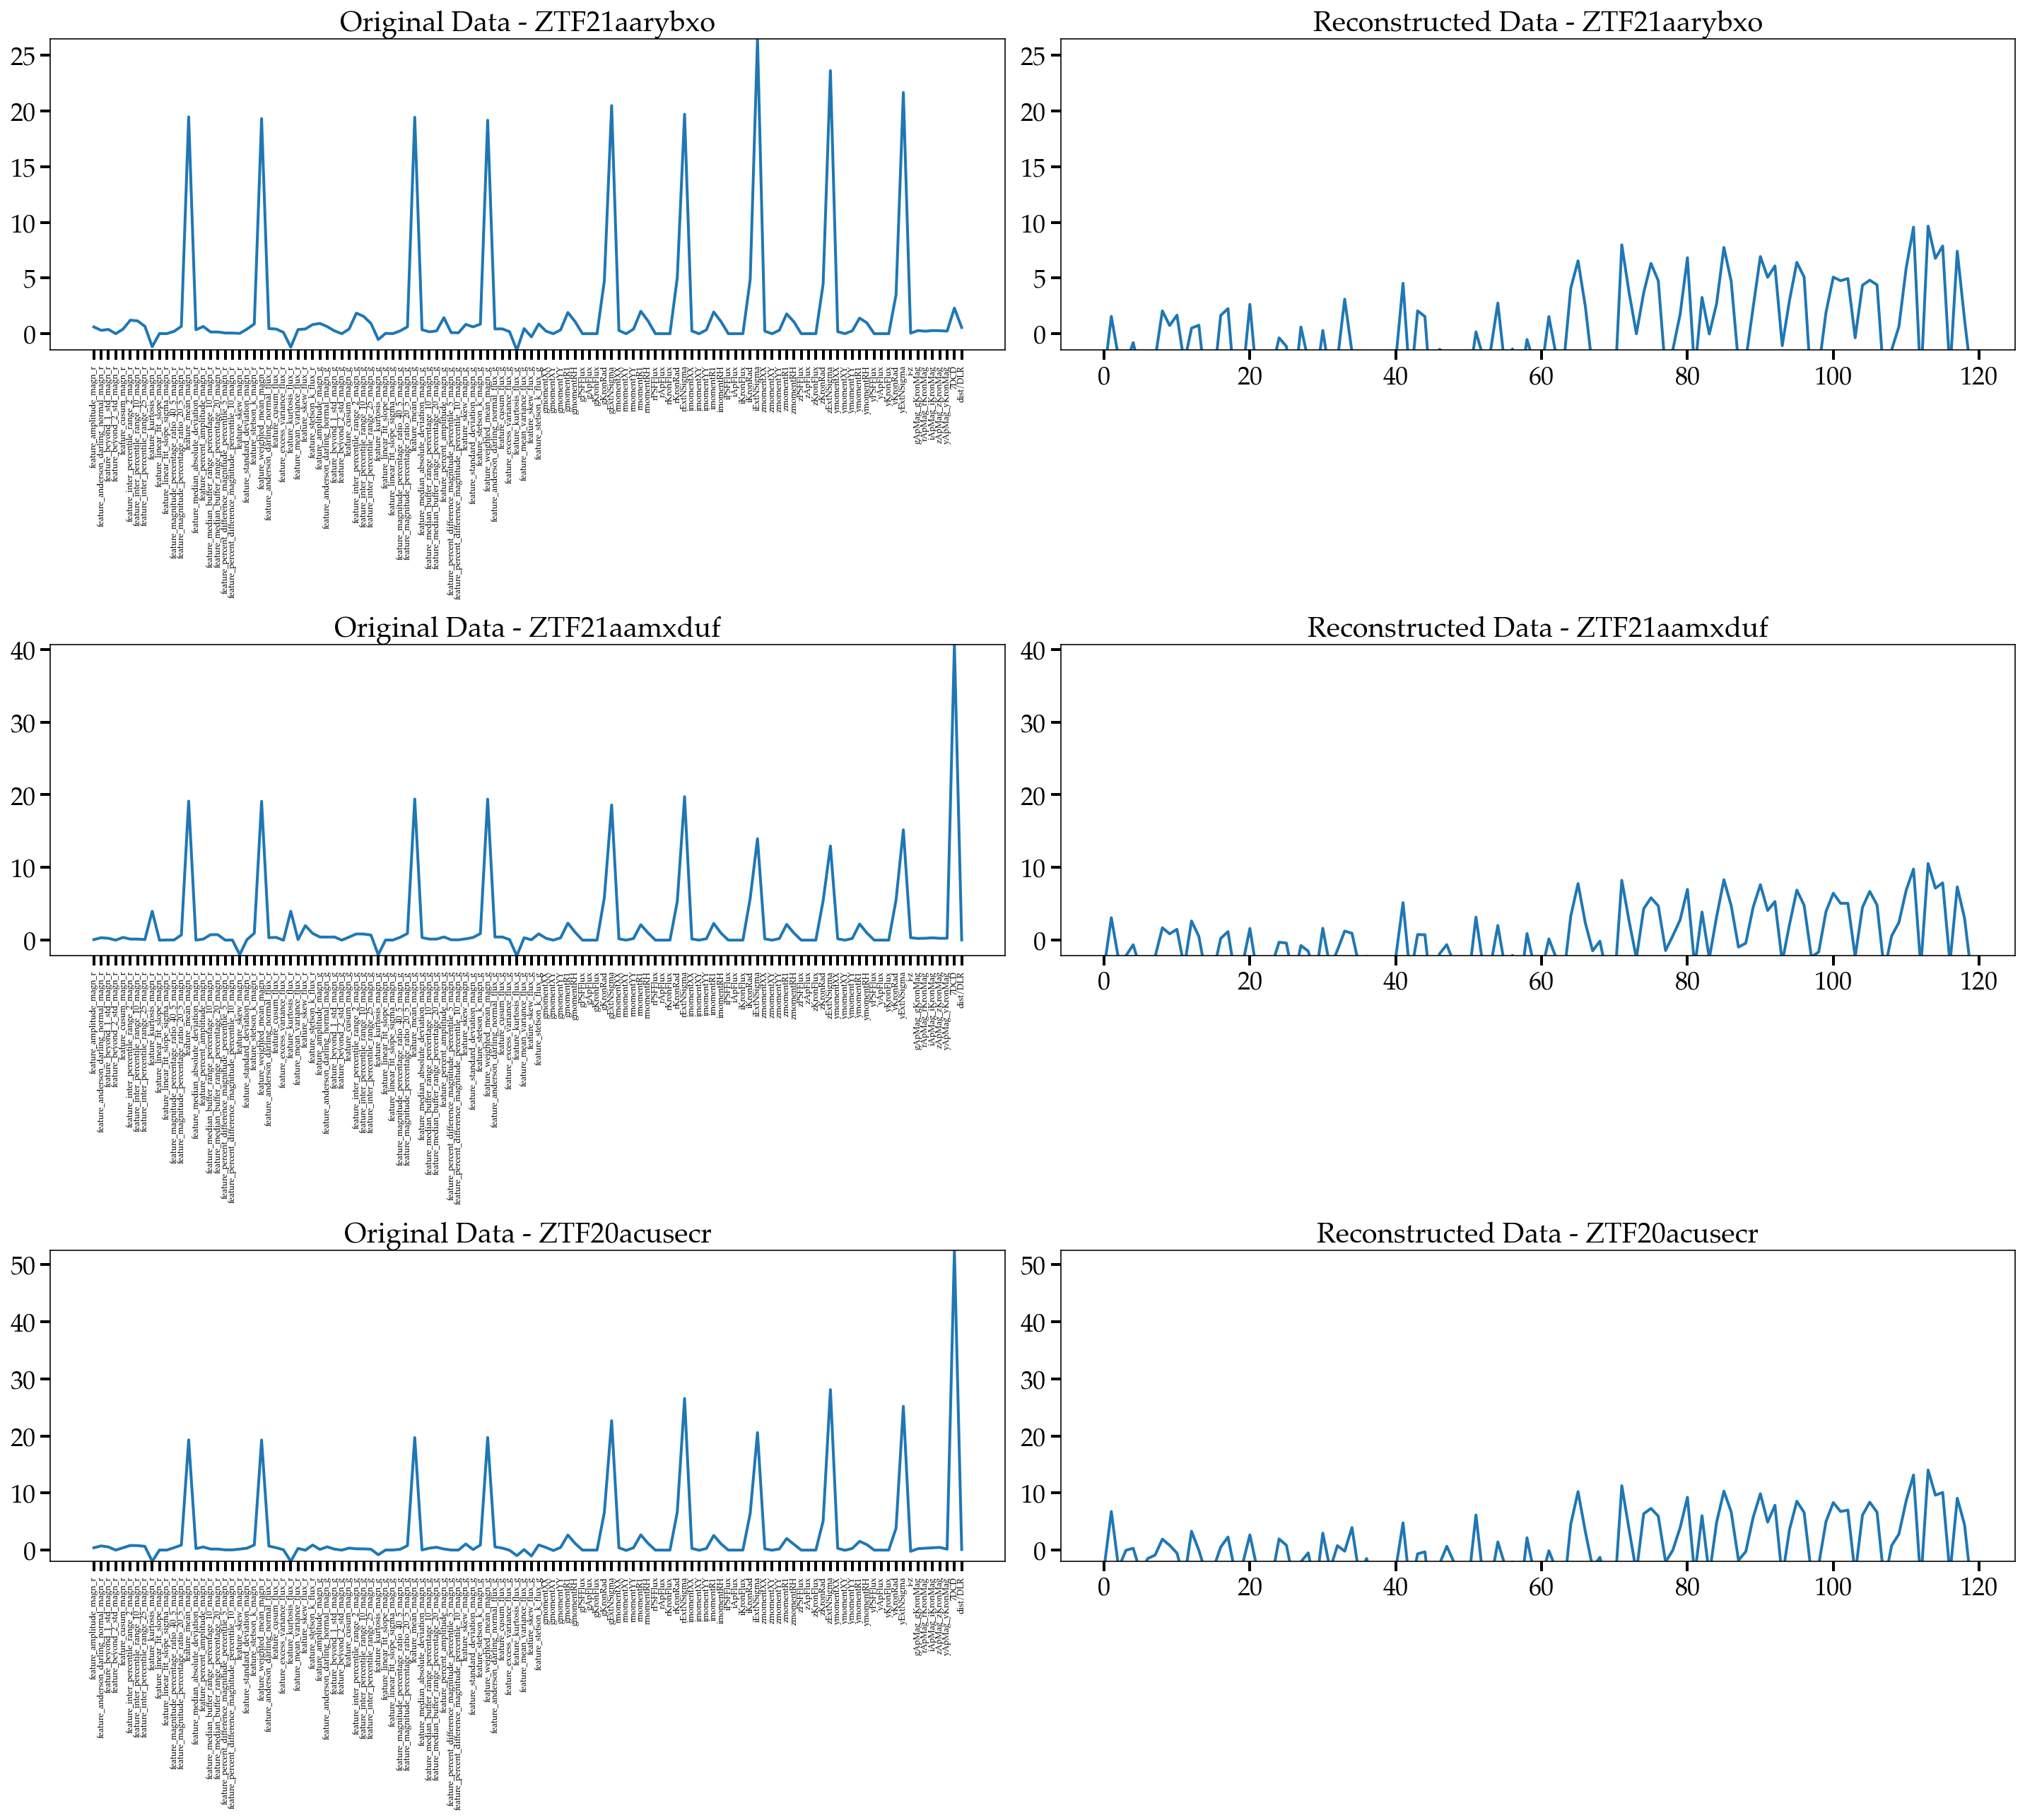

In [69]:
import matplotlib.pyplot as plt
import random

# Select a random sample of data points from x_test
num_samples = 3
random.seed(10)
random_indices = random.sample(range(len(x_test)), num_samples)

# Plot original data and reconstructed data
fig, axes = plt.subplots(num_samples, 2, figsize=(20, 6 * num_samples))
for i, index in enumerate(random_indices):
    try:
        # Plot original data
        y_min, y_max=np.min(x_test.iloc[index]), np.max(x_test.iloc[index])
        axes[i, 0].plot(x_test.iloc[index])
        axes[i, 0].set_title(f"Original Data - {x_test.iloc[index].name}")
        axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)
        axes[i, 0].set_ylim([y_min, y_max])  # Set y-scale limits

        # Plot reconstructed data
        axes[i, 1].plot(decoded_data[index])
        axes[i, 1].set_title(f"Reconstructed Data - {x_test.iloc[index].name}")
        #axes[i, 1].set_xticklabels(list(x_test.columns), rotation=90, fontsize=6)
        axes[i, 1].set_ylim([y_min, y_max])  # Set y-scale limits
    except KeyError:
        continue

plt.tight_layout()
plt.savefig('../figures/VAE/original_vs_reconstructed_data_test.jpg', dpi=150, bbox_inches='tight')
plt.show()


In [50]:
random.sample(range(len(x_test)), num_samples)

[361, 268, 141, 267, 415]

In [51]:
x_test.iloc[index]

feature_amplitude_magn_r                  0.987303
feature_anderson_darling_normal_magn_r    1.645826
feature_beyond_1_std_magn_r               0.137931
feature_beyond_2_std_magn_r               0.034483
feature_cusum_magn_r                      0.388388
                                            ...   
iApMag_iKronMag                           0.237099
zApMag_zKronMag                           0.232601
yApMag_yKronMag                          -0.039999
7DCD                                      6.558566
dist/DLR                                  1.468006
Name: ZTF21abpyauz, Length: 120, dtype: float32

In [55]:
x_test.iloc[index].name

'ZTF20aciuciv'

In [62]:
len(decoded_data[index])

120

In [63]:
x_test.columns

Index(['feature_amplitude_magn_r', 'feature_anderson_darling_normal_magn_r',
       'feature_beyond_1_std_magn_r', 'feature_beyond_2_std_magn_r',
       'feature_cusum_magn_r', 'feature_inter_percentile_range_2_magn_r',
       'feature_inter_percentile_range_10_magn_r',
       'feature_inter_percentile_range_25_magn_r', 'feature_kurtosis_magn_r',
       'feature_linear_fit_slope_magn_r',
       ...
       'yKronRad', 'yExtNSigma', 'i-z', 'gApMag_gKronMag', 'rApMag_rKronMag',
       'iApMag_iKronMag', 'zApMag_zKronMag', 'yApMag_yKronMag', '7DCD',
       'dist/DLR'],
      dtype='object', length=120)